# Loan Status Prediction: Lending Club, 2007-2017

***By Joe Corliss***

## Table of Contents

(Currently outdated)

1. [Summary](#1)
    1. [Spoilers](#1.1)
2. [Import the Data](#2)
3. [Target Variable](#3)
4. [Feature Selection](#4)
    1. [Drop columns that have only one distinct value](#4.1)
    2. [Remove columns that have < 2% data](#4.2)
    3. [Remove irrelevant features](#4.3)
    4. [Remove features that could make predictions too easy](#4.4)
    5. [Inspect non-numerical features](#4.5)
5. [Exploratory Data Analysis](#5)
6. [Correlations with 'charged_off'](#6)
    1. [Create dummy variables](#6.1)
    2. [Compute correlations with 'charged_off'](#6.2)
7. [More Pre-processing](#7)
    1. [Train/test split](#7.1)
    2. [Imputation with mean substitution](#7.2)
    3. [Standardize the data](#7.3)
8. [Predictive Modeling: SGDClassifier](#8)
    1. [Train with grid search](#8.1)
    2. [Test set evaluation](#8.2)

# Introduction

[Data source on Kaggle](https://www.kaggle.com/wordsforthewise/lending-club)

[Older, smaller dataset](https://www.kaggle.com/wendykan/lending-club-loan-data)

[Notebook on Kaggle](https://www.kaggle.com/pileatedperch/predicting-loan-status-mcc-0-73)

[Lending Club Statistics](https://www.lendingclub.com/info/download-data.action)

[GitHub Repository](https://github.com/jgcorliss/lending-club)

The goal of this project is to predict whether a loan will be fully paid or charged off. We'll remove some features that would make this prediction too easy, such as the total payments received on the loan to date.

# Import the Data
<a id="2"></a>

Import basic libraries.

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
#mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read in the data.

In [4]:
df = pd.read_csv('accepted_2007_to_2017Q3.csv.gz', compression='gzip')

C:\Users\Joe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check basic dataframe info.

In [5]:
df.shape

(1646801, 150)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


Sample some rows:

In [7]:
df.sample(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
920720,3632084,NaN,7500.0,7500.0,7500.0,36 months,14.33,257.54,C,C1,Blu Perspective,4 years,MORTGAGE,41000.0,Not Verified,Mar-2013,Fully Paid,n,NaN,debt_consolidation,Consolidation,482xx,MI,7.11,0.0,Feb-2006,700.0,704.0,1.0,51.0,NaN,12.0,0.0,10036.0,37.0,15.0,f,0.00,0.00,9052.727802,9052.73,7500.00,1552.73,0.0,0.0,0.0,Mar-2015,3137.69,NaN,Dec-2017,654.0,650.0,0.0,51.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,123507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27100.0,NaN,NaN,NaN,4.0,11228.0,11583.0,45.1,0.0,0.0,NaN,86.0,5.0,5.0,3.0,10.0,NaN,5.0,NaN,1.0,8.0,9.0,8.0,9.0,0.0,11.0,12.0,9.0,12.0,0.0,0.0,0.0,3.0,92.0,0.0,0.0,0.0,139954.0,10036.0,21100.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1293216,113151174,NaN,16000.0,16000.0,16000.0,60 months,24.85,468.22,E,E3,Project Coordinator,< 1 year,RENT,50000.0,Source Verified,Jul-2017,Current,n,NaN,credit_card,Credit card refinancing,958xx,CA,21.32,0.0,May-2007,680.0,684.0,0.0,NaN,88.0,8.0,1.0,12892.0,57.8,13.0,w,15286.63,15286.63,2296.920000,2296.92,713.37,1583.55,0.0,0.0,0.0,Dec-2017,468.22,Jan-2018,Dec-2017,719.0,715.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,32640.0,1.0,2.0,1.0,2.0,4.0,19748.0,87.0,1.0,2.0,4608.0,73.0,22300.0,0.0,1.0,5.0,5.0,4080.0,2277.0,82.5,0.0,0.0,40.0,122.0,12.0,4.0,0.0,12.0,NaN,5.0,NaN,0.0,3.0,6.0,3.0,5.0,3.0,6.0,9.0,6.0,8.0,0.0,0.0,0.0,2.0,100.0,66.7,1.0,0.0,45015.0,32640.0,13000.0,22715.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` column. What are the value counts in this column?

In [8]:
df['loan_status'].value_counts()

Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
Name: loan_status, dtype: int64

Let's only consider loans that meet the credit policy and have either been fully paid or charged off. These are the two cases we'll try to distinguish with a predictive model.

Retain only the rows with `loan_status` "Fully Paid" or "Charged Off."

In [9]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many observations remain?

In [10]:
df.shape

(814986, 150)

In [11]:
df['loan_status'].value_counts(normalize=True)

Fully Paid     0.793758
Charged Off    0.206242
Name: loan_status, dtype: float64

About 79% of the loans have been fully paid, and 21% have been charged off.

Let's convert the `loan_status` column to a binary `charged_off` column.

In [12]:
df['loan_status'] = df['loan_status'].isin(['Charged Off'])

In [13]:
df['loan_status'].value_counts(normalize=True, dropna=False)

False    0.793758
True     0.206242
Name: loan_status, dtype: float64

Rename the `loan_status` column to `charged_off`.

In [14]:
df.rename(columns={'loan_status':'charged_off'}, inplace=True)

Our target variable is ready to go. We have two classes to try to predict.

# Feature Selection
<a id="4"></a>

The dataset has 150 features, but we won't be using all the features to predict the loan status.

Definitions of the columns are given in the Lending Club "Data Dictionary" [available here](https://www.lendingclub.com/info/download-data.action).

First let's locate columns with missing data:

## Missing Data

In [15]:
def incomplete_cols(df):
    cmp = df.notnull().mean().sort_values()
    return cmp.loc[cmp<1]

In [16]:
incmpl_cols = incomplete_cols(df)
incmpl_cols

member_id                                     0.000000
next_pymnt_d                                  0.000000
orig_projected_additional_accrued_interest    0.000124
sec_app_mths_since_last_major_derog           0.000372
hardship_status                               0.000725
hardship_end_date                             0.000725
payment_plan_start_date                       0.000725
hardship_length                               0.000725
hardship_dpd                                  0.000725
hardship_start_date                           0.000725
hardship_amount                               0.000725
hardship_payoff_balance_amount                0.000725
hardship_last_payment_amount                  0.000725
hardship_reason                               0.000725
hardship_type                                 0.000725
hardship_loan_status                          0.000725
deferral_term                                 0.000725
sec_app_revol_util                            0.001081
sec_app_fi

In [17]:
incmpl_cols = incmpl_cols.index

There are LOTS of features with missing data.

## Create features indicating missing data

In [18]:
for col in incmpl_cols:
    df[col+'_NA'] = df[col].isnull()

In [19]:
df.shape

(814986, 254)

Remove duplicate columns.

In [20]:
cols_to_remove = []
for m in range(150, 252):
    for n in range(m+1, 253):
        if (df.iloc[:,m] == df.iloc[:,n]).all():
            cols_to_remove.append(df.columns[m])
            break

In [21]:
df.drop(labels=cols_to_remove, axis=1, inplace=True)

In [22]:
df.shape

(814986, 194)

## Drop features that have >30% missing data
<a id="4.2"></a>

Find the features to drop:

In [23]:
drop_list = []
for col in df.columns:
    if df[col].isnull().mean() > 0.3:
        drop_list.append(col)

drop_list

['member_id',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_

Drop these columns.

In [24]:
df.shape

(814986, 194)

In [25]:
df.drop(labels=drop_list, axis=1, inplace=True)

In [26]:
df.shape

(814986, 136)

## Remove irrelevant features
<a id="4.3"></a>

Let's drop some features that we don't think will be useful for predicting the loan status.

Analyzing text in the borrower loan description, job title, or loan title could be an interesting direction, but we won't explore this for now. The last three features listed below contain date information. We could convert these to numerical values, but we won't bother doing so.

In [27]:
df.shape

(814986, 136)

In [28]:
df.drop(labels=['id', 'emp_title', 'title', 'issue_d', 'last_credit_pull_d', 'earliest_cr_line'], axis=1, inplace=True)

In [29]:
df.shape

(814986, 130)

## Remove features that could make predictions too easy
<a id="4.4"></a>

Some features perfectly predict the loan status. For example, if `debt_settlement_flag` is 'Y', this implies that the borrower charged off. Also, if `total_pymnt` is greater than `loan_amnt`, and similarly for interest and fee payment features, then the loan must be paid off. Let's remove these columns so that predicting charge-offs isn't trivially simple.

In [30]:
df.shape

(814986, 130)

In [31]:
df.drop(labels=['collection_recovery_fee', 'debt_settlement_flag', 'last_pymnt_amnt', 'last_pymnt_d', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp'], axis=1, inplace=True)

In [32]:
df.shape

(814986, 120)

## Inspect non-numerical features
<a id="4.5"></a>

We're going to inspect features of type `object`, i.e. text data.

In [33]:
df.sample(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,charged_off,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,next_pymnt_d_NA,orig_projected_additional_accrued_interest_NA,sec_app_mths_since_last_major_derog_NA,deferral_term_NA,sec_app_revol_util_NA,sec_app_inq_last_6mths_NA,dti_joint_NA,debt_settlement_flag_date_NA,desc_NA,mths_since_last_record_NA,il_util_NA,mths_since_rcnt_il_NA,all_util_NA,inq_last_12m_NA,inq_fi_NA,mths_since_recent_bc_dlq_NA,mths_since_last_major_derog_NA,mths_since_recent_revol_delinq_NA,mths_since_last_delinq_NA,mths_since_recent_inq_NA,num_tl_120dpd_2m_NA,mo_sin_old_il_acct_NA,pct_tl_nvr_dlq_NA,avg_cur_bal_NA,num_rev_accts_NA,mo_sin_old_rev_tl_op_NA,num_bc_tl_NA,num_sats_NA,bc_util_NA,percent_bc_gt_75_NA,bc_open_to_buy_NA,mths_since_recent_bc_NA,emp_title_NA,mort_acc_NA,emp_length_NA,title_NA,last_pymnt_d_NA,pub_rec_bankruptcies_NA,revol_util_NA,collections_12_mths_ex_med_NA,last_credit_pull_d_NA,tax_liens_NA,dti_NA,inq_last_6mths_NA
1359281,5700.0,5700.0,5700.0,36 months,9.75,183.26,B,B3,10+ years,MORTGAGE,76000.0,Source Verified,False,n,home_improvement,282xx,NC,13.47,0.0,745.0,749.0,1.0,19.0,0.0,14145.0,26.8,25.0,w,0.0,0.0,659.0,655.0,0.0,1.0,Individual,0.0,0.0,39115.0,52700.0,12.0,2059.0,17940.0,34.3,0.0,0.0,25.0,218.0,3.0,3.0,0.0,4.0,1.0,0.0,3.0,5.0,7.0,10.0,3.0,17.0,22.0,5.0,19.0,0.0,0.0,0.0,5.0,100.0,14.3,0.0,0.0,87698.0,39115.0,27300.0,34998.0,N,Cash,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
807397,5000.0,5000.0,5000.0,36 months,13.98,170.84,C,C1,2 years,MORTGAGE,87000.0,Verified,False,n,credit_card,601xx,IL,16.81,0.0,675.0,679.0,1.0,7.0,1.0,24449.0,91.9,23.0,w,0.0,0.0,694.0,690.0,0.0,1.0,Individual,0.0,0.0,207056.0,26600.0,5.0,34509.0,0.0,101.6,0.0,0.0,136.0,190.0,89.0,6.0,4.0,134.0,6.0,0.0,1.0,2.0,1.0,2.0,12.0,3.0,7.0,2.0,7.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,1.0,220200.0,46521.0,16700.0,31589.0,N,Cash,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
127409,9875.0,9875.0,9875.0,36 months,13.35,334.40,C,C2,10+ years,MORTGAGE,22560.0,Source Verified,False,n,debt_consolidation,441xx,OH,15.00,0.0,715.0,719.0,1.0,9.0,1.0,9497.0,43.4,11.0,f,0.0,0.0,684.0,680.0,0.0,1.0,Individual,0.0,0.0,81526.0,21900.0,1.0,9058.0,9309.0,47.4,0.0,0.0,NaN,101.0,3.0,3.0,2.0,3.0,3.0,0.0,5.0,6.0,6.0,6.0,0.0,8.0,9.0,6.0,9.0,0.0,0.0,0.0,1.0,90.9,16.7,1.0,0.0,109640.0,9497.0,17700.0,0.0,N,Cash,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Which columns have text data?

In [34]:
text_cols = []
for col in df.columns:
    if df[col].dtype == np.object:
        text_cols.append(col)

text_cols

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method']

### term

In [37]:
df['term'].value_counts(dropna=False)

 36 months    618460
 60 months    196526
Name: term, dtype: int64

Convert `term` to integer values.

In [38]:
df['term'] = df['term'].apply(lambda s:np.int8(s[1:3])) # There's an extra space in the data for some reason

In [40]:
df['term'].value_counts()

36    618460
60    196526
Name: term, dtype: int64

### grade, sub_grade

In [44]:
df['grade'].value_counts().sort_index()

A    133475
B    235225
C    225917
D    127665
E     63559
F     23112
G      6033
Name: grade, dtype: int64

The grade is implied by the subgrade, so let's drop the grade column.

In [45]:
df.drop(labels=['grade'], axis=1, inplace=True)

### emp_length

In [47]:
df['emp_length'].value_counts(dropna=False).sort_index()

1 year        53411
10+ years    264873
2 years       73493
3 years       64999
4 years       48752
5 years       52149
6 years       40290
7 years       39407
8 years       38887
9 years       31900
< 1 year      64572
NaN           42253
Name: emp_length, dtype: int64

Let's convert `emp_length` to floats:

In [48]:
def emp_conv(s):
    try:
        if pd.isnull(s):
            return s
        elif s[0] == '<':
            return 0.0
        elif s[:2] == '10':
            return 10.0
        else:
            return np.float16(s[0])
    except TypeError:
        return np.float16(s)

In [49]:
df['emp_length'] = df['emp_length'].apply(lambda s: emp_conv(s))

In [51]:
df['emp_length'].value_counts(dropna=False).sort_index()

 0.0      64572
 1.0      53411
 2.0      73493
 3.0      64999
 4.0      48752
 5.0      52149
 6.0      40290
 7.0      39407
 8.0      38887
 9.0      31900
 10.0    264873
NaN       42253
Name: emp_length, dtype: int64

### home_ownership

In [52]:
df['home_ownership'].value_counts()

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          144
ANY             94
NONE            46
Name: home_ownership, dtype: int64

### verification_status

In [53]:
df['verification_status'].value_counts()

Source Verified    293897
Verified           269895
Not Verified       251194
Name: verification_status, dtype: int64

### pymnt_plan

In [54]:
df['pymnt_plan'].value_counts(dropna=False)

n    814986
Name: pymnt_plan, dtype: int64

This feature will be removed automatically later.

### purpose

In [55]:
df['purpose'].value_counts()

debt_consolidation    481652
credit_card           175123
home_improvement       50793
other                  43900
major_purchase         17463
small_business         10214
car                     8936
medical                 8772
moving                  5725
vacation                5116
house                   4095
wedding                 2272
renewable_energy         599
educational              326
Name: purpose, dtype: int64

### zip_code, addr_state

In [56]:
df['zip_code'].nunique()

925

In [57]:
df['addr_state'].nunique()

51

There are a lot of zip codes, so let's just retain the state column.

In [59]:
df.drop(labels=['zip_code'], axis=1, inplace=True)

### initial_list_status

In [60]:
df['initial_list_status'].value_counts()

f    413678
w    401308
Name: initial_list_status, dtype: int64

I wasn't able to determine what the initial list status means.

### application_type

In [61]:
df['application_type'].value_counts()

Individual    811207
Joint App       3779
Name: application_type, dtype: int64

### hardship_flag

In [62]:
df['hardship_flag'].value_counts()

N    814986
Name: hardship_flag, dtype: int64

This feature will be removed automatically later.

### disbursement_method

In [63]:
df['disbursement_method'].value_counts()

Cash         813877
DirectPay      1109
Name: disbursement_method, dtype: int64

# Exploratory Data Analysis
<a id="5"></a>

View some random rows:

In [ ]:
df.sample(3)

Let's make a count plot of the loan purpose, separated by the `charged_off` value.

In [ ]:
plt.figure(figsize=(12,6), dpi=100)
sns.countplot(y='purpose', hue='charged_off', data=df, orient='h')

It appears that most of the charge-offs come from loans for debt consolidation or to pay off credit cards.

Let's make a similar plot, but with `sub_grade` instead of `purpose`.

In [ ]:
plt.figure(figsize=(16,6), dpi=120)
sns.countplot(x='sub_grade', hue='charged_off', data=df, order=sorted(df['sub_grade'].value_counts().index))

There's a clear trend of higher probability of charge-off as the subgrade worsens.

Let's make a similar plot, but with `term` instead of `sub_grade`.

In [ ]:
plt.figure(figsize=(4,4), dpi=90)
sns.countplot(x='term', hue='charged_off', data=df)

Loans with a term of 60 months are much more likely to be charged off.

Now let's compare the interest rate to the loan status using a kdeplot, which approximates the probability distribution of the data.

In [ ]:
plt.figure(figsize=(10,4), dpi=90)
sns.distplot(df['int_rate'].loc[df['charged_off']==0], kde=True, label='charged_off = 0')
sns.distplot(df['int_rate'].loc[df['charged_off']==1], kde=True, label='charged_off = 1')
plt.xlabel('int_rate')
plt.ylabel('density')
plt.legend()

Charged-off loans tend to have higher interest rates.

Now let's compare the borrower's most recent FICO score (a credit score) to the loan status.

In [ ]:
plt.figure(figsize=(10,4), dpi=90)
sns.distplot(df['last_fico_range_high'].loc[df['charged_off']==0], label='charged_off = 0')
sns.distplot(df['last_fico_range_high'].loc[df['charged_off']==1], label='charged_off = 1')
plt.xlabel('last_fico_range_high')
plt.ylabel('density')
plt.legend()

There's a strong association here: charged-off loans tend to have much lower FICO scores.

# More Pre-processing
<a id="7"></a>

## Create dummy variables
<a id="6.1"></a>

In [64]:
df.shape

(814986, 118)

In [65]:
df = pd.get_dummies(df, drop_first=True)

In [66]:
df.shape

(814986, 225)

Now all the features are numerical. What does the data look like after converting categorical features to dummy variables?

In [ ]:
df.sample(3)

## Automatic feature selection

Remove features that have no variance.

In [83]:
from sklearn.feature_selection import VarianceThreshold

## Train/test split
<a id="7.1"></a>

In [67]:
X = df.drop(labels=['charged_off'], axis=1) # Features
y = df.loc[:,'charged_off'] # Response variable
df = None

In [68]:
from sklearn.model_selection import train_test_split

Let's do a 90/10 train/test split.

In [69]:
random_state = 1 # Just to make the results fixed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state, stratify=y)
X = None
y = None

## Imputation with mean substitution
<a id="7.2"></a>

How complete is our training data?

In [70]:
incomplete_cols(X_train)

mths_since_recent_inq         0.855860
num_tl_120dpd_2m              0.885714
mo_sin_old_il_acct            0.890249
pct_tl_nvr_dlq                0.917091
avg_cur_bal                   0.917242
mo_sin_old_rev_tl_op          0.917257
mo_sin_rcnt_rev_tl_op         0.917257
num_rev_accts                 0.917257
num_actv_bc_tl                0.917258
total_rev_hi_lim              0.917258
mo_sin_rcnt_tl                0.917258
num_accts_ever_120_pd         0.917258
num_bc_tl                     0.917258
tot_cur_bal                   0.917258
num_il_tl                     0.917258
num_op_rev_tl                 0.917258
num_rev_tl_bal_gt_0           0.917258
num_tl_30dpd                  0.917258
num_tl_90g_dpd_24m            0.917258
num_tl_op_past_12m            0.917258
tot_hi_cred_lim               0.917258
num_actv_rev_tl               0.917258
tot_coll_amt                  0.917258
total_il_high_credit_limit    0.917258
num_bc_sats                   0.931642
num_sats                 

The learning algorithms cannot have missing data. Perform mean substitution, using only the means of the training set to prevent test set leakage.

In [71]:
from sklearn.preprocessing import Imputer

In [72]:
imputer = Imputer().fit(X_train)

In [73]:
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(imputer.transform(X_test),  columns=X_test.columns)

## Standardize the data
<a id="7.3"></a>

Shift and scale each column individually so that it has zero mean and unit variance. This will help the learning algorithms.

Train the scaler using only the training data to prevent test set leakage.

In [74]:
from sklearn.preprocessing import StandardScaler

In [75]:
scaler = StandardScaler().fit(X_train)

In [76]:
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

# Predictive Modeling: SGDClassifier
<a id="8"></a>

I decided to use a SGD Classifier by looking at the machine learning flowchart here: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html.

The SGDClassifier estimator implements linear classifiers (SVM, logistic regression, a.o.) with SGD training. The linear classifier is chosen by the 'loss' hyperparameter.

In [80]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer

## Train with grid search
<a id="8.1"></a>

We're going to search through many hyperparameters of SGDClassifier using an exhaustive grid search with 3-fold cross-validation, implemented in GridSearchCV.

Here are the hyperparameters that we'll try:

In [85]:
param_grid = [{'loss': ['hinge'],
               'alpha': [10.0**k for k in range(1,2)],
               'class_weight': [None, 'balanced']},
              {'loss': ['log'],
               'alpha': [10.0**k for k in range(1,2)],
               'penalty': ['l2', 'l1']}]

Instantiate the grid estimator. We'll use the Matthews correlation coefficient as our scoring metric.

In [86]:
grid = GridSearchCV(estimator=SGDClassifier(max_iter=1000, tol=1e-3, random_state=random_state, warm_start=True), param_grid=param_grid, scoring=make_scorer(matthews_corrcoef), n_jobs=4, pre_dispatch=8, verbose=1)

Run the grid search (this could take some time).

In [87]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  2.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=1, shuffle=True,
       tol=0.001, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'loss': ['hinge'], 'alpha': [10.0], 'class_weight': [None, 'balanced']}, {'loss': ['log'], 'alpha': [10.0], 'penalty': ['l2', 'l1']}],
       pre_dispatch=8, refit=True, return_train_score='warn',
       scoring=make_scorer(matthews_corrcoef), verbose=1)

Hyperparameters that gave the best results on the hold out data:

In [88]:
grid.best_params_

{'alpha': 10.0, 'class_weight': 'balanced', 'loss': 'hinge'}

Mean cross-validated MCC score of the best estimator:

In [89]:
grid.best_score_

0.35834719351907157

Weights assigned to the features by the best estimator:

Text(0.5,0,'classifier weight')

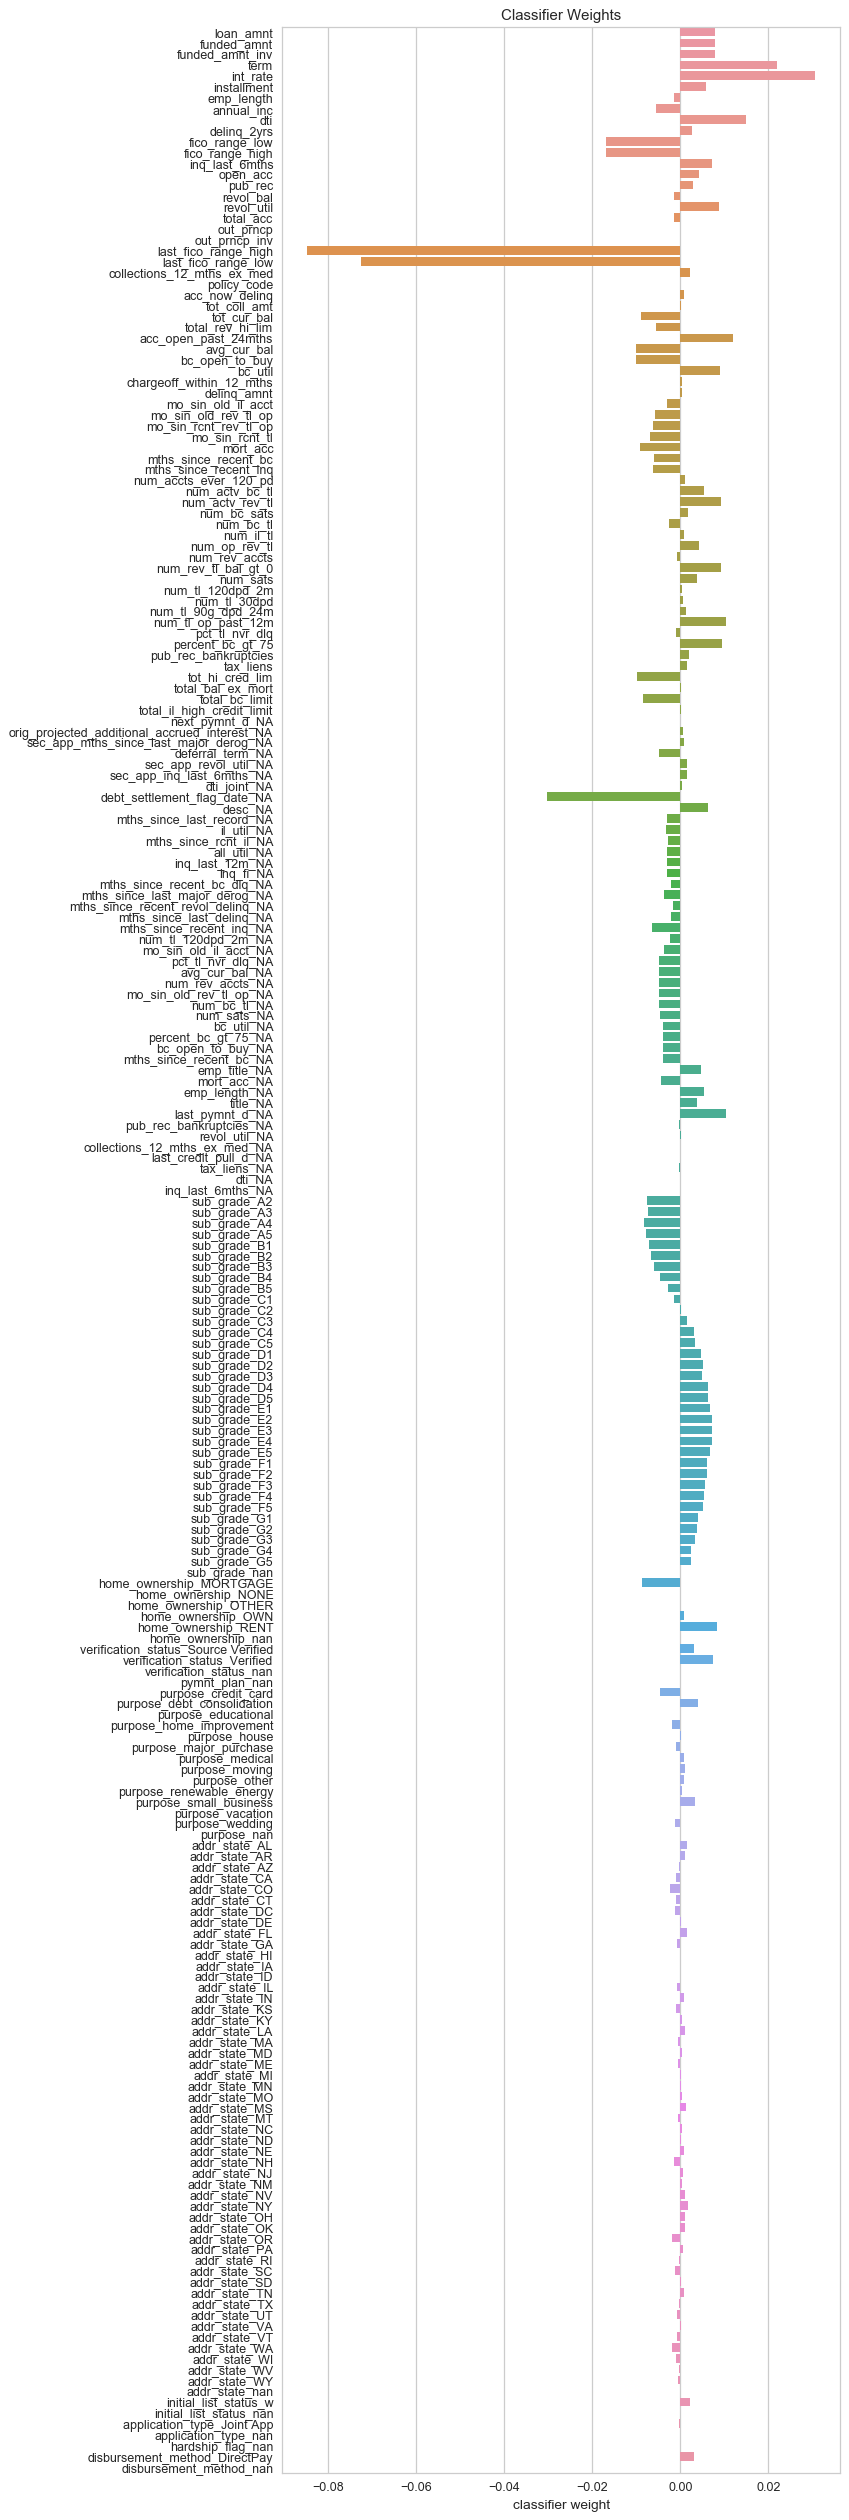

In [90]:
plt.figure(figsize=(8,36), dpi=90)
sns.barplot(y=X_train.columns, x=grid.best_estimator_.coef_[0,:], orient='h')
plt.title("Classifier Weights")
plt.xlabel("classifier weight")

## Test set evaluation
<a id="8.2"></a>

In [91]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

In [92]:
def classification_eval(estimator, X_test, y_test):
    """
    Print several metrics of classification performance of an estimator, given features X_test and labels y_test.
    
    Input: estimator or GridSearchCV instance, X_test, y_test
    Returns: text printout of metrics
    """
    y_pred = estimator.predict(X_test)
    
    # Number of decimal places based on number of samples
    dec = np.int64(np.ceil(np.log10(len(y_test))))
    
    print('Confusion matrix -----------------------'+3*(dec-1)*'-')
    print(confusion_matrix(y_test, y_pred), '\n')
    
    print('Classification report ------------------'+3*(dec-1)*'-')
    print(classification_report(y_test, y_pred, digits=dec))
    
    print('Scalar metrics -------------------------'+3*(dec-1)*'-')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    if y_test.nunique() <= 2: # Additional metrics for binary classification
        try:
            y_score = estimator.predict_proba(X_test)[:,1]
        except:
            y_score = estimator.decision_function(X_test)
        print(format_str % ('AUPRC', average_precision_score(y_test, y_score)))
        print(format_str % ('AUROCC', roc_auc_score(y_test, y_score)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))

Test set evaluation metrics:

In [93]:
classification_eval(grid, X_test, y_test)

Confusion matrix -----------------------------------
[[61752  2939]
 [ 7370  9438]] 

Classification report ------------------------------
             precision    recall  f1-score   support

      False    0.89338   0.95457   0.92296     64691
       True    0.76254   0.56152   0.64677     16808

avg / total    0.86639   0.87351   0.86600     81499

Scalar metrics -------------------------------------
          MCC = 0.58182
        AUPRC = 0.72984
       AUROCC = 0.89041
Cohen's kappa = 0.57188
     Accuracy = 0.87351
